In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lib.utils import train_nn_model, sr_tuning, log_to_mlflow, log_ann_to_mlflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error
from pysr import PySRRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import re
import optuna
import joblib
import mlflow

In [14]:
cwd = Path.cwd()
source_data = Path(cwd)/"data"
output = Path(cwd)/"output"
preprocessed_data = cwd/'output/preprocessed_data'

# Loading Dataset

In [15]:
salaries = pd.read_parquet(preprocessed_data/'preprocessed_data.parquet')
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16494 entries, 0 to 16493
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   experience_level      16494 non-null  object 
 1   company_size          16494 non-null  object 
 2   work_year             16494 non-null  object 
 3   remote_ratio          16494 non-null  object 
 4   salary_currency       16494 non-null  object 
 5   employment_type       16494 non-null  object 
 6   job_type              16494 non-null  object 
 7   employee_continent    16494 non-null  object 
 8   company_continent     16494 non-null  object 
 9   job_level             16494 non-null  object 
 10  exp_level_job         16494 non-null  object 
 11  exp_level_econtinent  16494 non-null  object 
 12  job_level_exp         16494 non-null  object 
 13  work_year_econtinent  16494 non-null  object 
 14  kmeans_group          16494 non-null  object 
 15  same_continent     

In [16]:
X_train = np.load(preprocessed_data/'preprocessed_X_train.npy')
y_train = np.load(preprocessed_data/'preprocessed_y_train.npy')
X_test = np.load(preprocessed_data/'preprocessed_X_test.npy')
y_test = np.load(preprocessed_data/'preprocessed_y_test.npy')

In [17]:
features = pd.read_csv(preprocessed_data/'final_features.csv')
features

,Unnamed: 0,0
0,nom__employee_continent_North America,0.330858
1,nom__kmeans_group_4,0.121863
2,nom__salary_currency_USD,0.088748
3,ord__experience_level,0.064487
4,remainder__GDP_USD,0.044038
...,...,...
146,nom__salary_currency_CLP,0.000000
147,nom__salary_currency_ZAR,0.000000
148,nom__job_level_exp_Head_MI,0.000000
149,nom__salary_currency_NZD,0.000000


# Deep Learning

In [18]:
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [19]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)  # ensures shape (N, 1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch [1/100], Train Loss: 14.5760, Test Loss: 0.4548
Epoch [2/100], Train Loss: 3.9719, Test Loss: 0.4098
Epoch [3/100], Train Loss: 3.5134, Test Loss: 0.4969
Epoch [4/100], Train Loss: 3.3694, Test Loss: 0.3549
Epoch [5/100], Train Loss: 3.2653, Test Loss: 0.9573
Epoch [6/100], Train Loss: 3.1100, Test Loss: 0.2965
Epoch [7/100], Train Loss: 2.9869, Test Loss: 0.2608
Epoch [8/100], Train Loss: 2.8433, Test Loss: 0.4238
Epoch [9/100], Train Loss: 2.6940, Test Loss: 0.2249
Epoch [10/100], Train Loss: 2.5328, Test Loss: 0.4269
Epoch [11/100], Train Loss: 2.4169, Test Loss: 0.2983
Epoch [12/100], Train Loss: 2.2765, Test Loss: 0.2347
Epoch [13/100], Train Loss: 2.0819, Test Loss: 0.2405
Epoch [14/100], Train Loss: 2.0671, Test Loss: 0.2172
Epoch [15/100], Train Loss: 1.8760, Test Loss: 0.2869
Epoch [16/100], Train Loss: 1.8090, Test Loss: 0.1493
Epoch [17/100], Train Loss: 1.6735, Test Loss: 0.2571
Epoch [18/100], Train Loss: 1.5849, Test Loss: 0.1750
Epoch [19/100], Train Loss: 1.5016, 

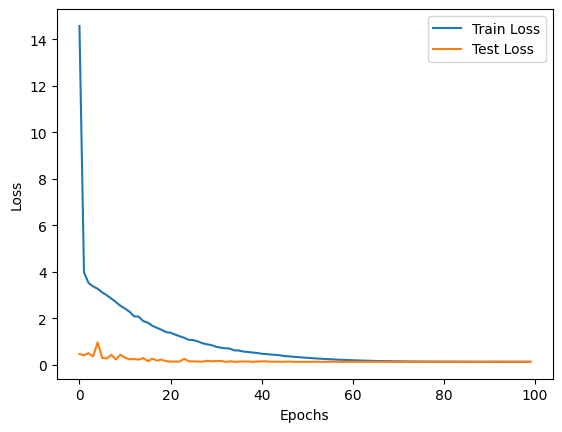

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ANNModel(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses = train_nn_model(model, train_loader, test_loader,
                                       criterion, optimizer, device, num_epochs=100)

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [39]:
model.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

model.eval()
with torch.no_grad():
    ann_y_pred = model(X_test_tensor)
    ann_y_pred = ann_y_pred.cpu().numpy().flatten()
ann_y_test = y_test_tensor.cpu().numpy().flatten()
ann_r2 = r2_score(ann_y_test, ann_y_pred)
ann_rmse = root_mean_squared_error(ann_y_test, ann_y_pred)
ann_mse = mean_squared_error(ann_y_test, ann_y_pred)
ann_mae = mean_absolute_error(ann_y_test, ann_y_pred)
ann_y_true_usd = np.exp(ann_y_test)
ann_y_pred_usd = np.exp(ann_y_pred)
ann_mse_usd = mean_squared_error(ann_y_true_usd, ann_y_pred_usd)
ann_rmse_usd = root_mean_squared_error(ann_y_true_usd, ann_y_pred_usd)
ann_mae_usd = mean_absolute_error(ann_y_true_usd, ann_y_pred_usd)
print("Test MSE:", ann_mse)
print("Test RMSE:", ann_rmse)
print("Test MAE:", ann_mae)
print("Test R2:", ann_r2)
print(f"Test RMSE in usd: {ann_rmse_usd:,.2f}")
print(f"Test MSE in usd: {ann_mse_usd:,.2f}")
print(f"Test MAE in usd: {ann_mae_usd:,.2f}")

Test MSE: 0.12042970955371857
Test RMSE: 0.34702983498573303
Test MAE: 0.27301034331321716
Test R2: 0.4613601565361023
Test RMSE in usd: 54,061.15
Test MSE in usd: 2,922,607,872.00
Test MAE in usd: 39,074.49


# Symbolic Regression

In [9]:
output_path = output/'pysr_outputs'

study, pysr_model, best_loss = sr_tuning(X_train, y_train, X_test, y_test, output_path)

print("Best hyperparameters:", study.best_params)
print("Best loss:", best_loss)


[I 2025-08-12 14:21:03,661] A new study created in memory with name: no-name-63dd81f7-5d25-4185-9f7b-93a71a6f2d7a
/home/hien/Work/AI/SDS-CP032-mlpaygrade/.venv/lib/python3.12/site-packages/pysr/sr.py:1469: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory.
  warnings.warn(
/home/hien/Work/AI/SDS-CP032-mlpaygrade/.venv/lib/python3.12/site-packages/pysr/sr.py:1873: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[I 2025-08-12 14:24:00,378] Trial 0 finished with value: 0.1388359347416892 and parameters: {'niterations': 155, 'population_size': 176, 'populations': 92, 'maxsize': 65, 'parsimony': 0.0886763722309148, 'ncycles_per_iteration': 1244}. Best is trial 0 with value: 0.1388359347416892.
/home/hien/Work/AI/SDS-CP032-mlpaygrade/.venv/lib/python3.12/site-packages/pysr/sr.py:1873: UserWarning: Not

Best hyperparameters: {'niterations': 201, 'population_size': 120, 'populations': 42, 'maxsize': 78, 'parsimony': 0.07621998075295422, 'ncycles_per_iteration': 1072}
Best loss: 0.13134336344630182


In [41]:
symbolic_eq = pysr_model.get_best()
best_equation = pysr_model.sympy()
y_pred = pysr_model.predict(X_test)
pysr_r2 = r2_score(y_test, y_pred)
pysr_rmse = root_mean_squared_error(y_test, y_pred)
pysr_mse = mean_squared_error(y_test, y_pred)
pysr_mae = mean_absolute_error(y_test, y_pred)
pysr_y_true_usd = np.exp(y_test)
pysr_y_pred_usd = np.exp(y_pred)
pysr_mse_usd = mean_squared_error(pysr_y_true_usd, pysr_y_pred_usd)
pysr_rmse_usd = root_mean_squared_error(pysr_y_true_usd, pysr_y_pred_usd)
pysr_mae_usd = mean_absolute_error(pysr_y_true_usd, pysr_y_pred_usd)
print("Test MSE:", pysr_mse)
print("Test RMSE:", pysr_rmse)
print("Test MAE:", pysr_mae)
print("Test R2:", pysr_r2)
print("Best equation:", best_equation)
print(f"Test RMSE in usd: {pysr_rmse_usd:,.2f}")
print(f"Test MSE in usd: {pysr_mse_usd:,.2f}")
print(f"Test MAE in usd: {pysr_mae_usd:,.2f}")

Test MSE: 0.13084103182814563
Test RMSE: 0.36171954858446015
Test MAE: 0.2827402595811307
Test R2: 0.4147939630113606
Best equation: 11.656504 - (-1)*0.10735378*(x0 + x40 + x59 - (x141 - x25 + x33 + 1.8043643) - (-1)*0.10735378*(x0 - 0.72659254*x106 + x141 + x149 + x33 - sin(0.20380472) + 1.8043643 + 2.2645884)/0.4817265 + 2.2645884)
Test RMSE in usd: 55,028.73
Test MSE in usd: 3,028,160,752.11
Test MAE in usd: 40,069.31


In [42]:
equation_str = str(best_equation)
# Find all 'xNN' variable indices (NN as integer)
variable_indices = [int(x[1:]) for x in re.findall(r'x\d+', equation_str)]
unique_variable_indices = sorted(set(variable_indices))
# Print x_index and its feature name side by side
for idx in unique_variable_indices:
    feature_name = features.iloc[idx, 0]
    print(f"x{idx}: {feature_name}")


x0: nom__employee_continent_North America
x25: nom__exp_level_job_SE_Others
x33: nom__employment_type_FT
x40: nom__exp_level_job_MI_BI
x59: nom__work_year_econtinent_2024_Africa
x106: nom__work_year_econtinent_2020_North America
x141: nom__work_year_econtinent_2024_South America
x149: nom__salary_currency_NZD


<Axes: xlabel='complexity'>

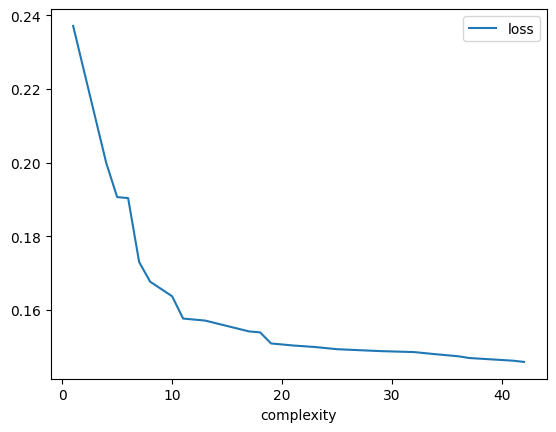

In [12]:
sr_training_loss = pysr_model.equations_
sr_training_loss.plot(x="complexity", y="loss")

In [24]:
joblib.dump(pysr_model, output/"models/pysr_regressor.joblib")
joblib.dump(model, output/"models/ann_regressor.joblib")

['/home/hien/Work/AI/SDS-CP032-mlpaygrade/submissions/team-members/hien-nguyen/output/models/ann_regressor.joblib']

In [44]:
mlflow.set_experiment("salary_prediction")
# log_to_mlflow(pysr_model, 'symbolic_regression', 'pysr', pysr_r2, pysr_rmse, pysr_mse, pysr_mae)
# ann_params = {
#     "epochs": 100,
#     "learning_rate": 0.001,
#     "batch_size": 32,
#     "optimizer": "Adam"
# }
# log_ann_to_mlflow(model, 'deep_learning', 'mlp', ann_r2, ann_rmse, ann_mse, ann_mae, ann_params)

<Experiment: artifact_location='file:///home/hien/Work/AI/SDS-CP032-mlpaygrade/submissions/team-members/hien-nguyen/mlruns/666463114177868666', creation_time=1754627494217, experiment_id='666463114177868666', last_update_time=1754627494217, lifecycle_stage='active', name='salary_prediction', tags={}>

In [45]:
! mlflow ui

[2025-08-18 12:48:09 +1200] [324817] [INFO] Starting gunicorn 23.0.0
[2025-08-18 12:48:09 +1200] [324817] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-08-18 12:48:09 +1200] [324817] [ERROR] connection to ('127.0.0.1', 5000) failed: [Errno 98] Address already in use
[2025-08-18 12:48:10 +1200] [324817] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-08-18 12:48:10 +1200] [324817] [ERROR] connection to ('127.0.0.1', 5000) failed: [Errno 98] Address already in use
[2025-08-18 12:48:11 +1200] [324817] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-08-18 12:48:11 +1200] [324817] [ERROR] connection to ('127.0.0.1', 5000) failed: [Errno 98] Address already in use
[2025-08-18 12:48:12 +1200] [324817] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-08-18 12:48:12 +1200] [324817] [ERROR] connection to ('127.0.0.1', 5000) failed: [Errno 98] Address already in use
[2025-08-18 12:48:13 +1200] [324817] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-08-18 12:48:13 +1200]